## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import random
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [2]:
# reading the Treebank tagged sentences
nltk.download('universal_tagset')
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/apurvshingne/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [3]:
nltk_data[:2]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')]]

In [4]:
train_set, test_set = train_test_split(nltk_data,test_size=0.05,random_state=42)

print(len(train_set))
print(len(test_set))
#95 % train set
print(len(train_set)/(len(nltk_data)))
print(train_set[:40])

3718
196
0.9499233520694941
[[('Bank', 'NOUN'), ('of', 'ADP'), ('New', 'NOUN'), ('England', 'NOUN'), ("'s", 'PRT'), ('shares', 'NOUN'), ('are', 'VERB'), ('traded', 'VERB'), ('*-1', 'X'), ('on', 'ADP'), ('the', 'DET'), ('New', 'NOUN'), ('York', 'NOUN'), ('Stock', 'NOUN'), ('Exchange', 'NOUN'), ('.', '.')], [('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('due', 'ADJ'), ('1991-2000', 'NUM'), ('and', 'CONJ'), ('2009', 'NUM'), (',', '.'), ('tentatively', 'ADV'), ('priced', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('a', 'DET'), ('Chemical', 'NOUN'), ('Securities', 'NOUN'), ('Inc.', 'NOUN'), ('group', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('yield', 'VERB'), ('from', 'ADP'), ('6.20', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('1991', 'NUM'), ('to', 'PRT'), ('7.272', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('2009', 'NUM'), ('.', '.')], [('``', '.'), ('Th

In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95589

In [6]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Bank', 'of', 'New', 'England', "'s", 'shares', 'are', 'traded', '*-1', 'on']

In [7]:
# vocabulary
V = set(tokens)
print(len(V))

12109


In [8]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [9]:
print(T)

{'DET', 'X', 'ADP', 'ADJ', 'CONJ', 'PRON', 'ADV', '.', 'PRT', 'VERB', 'NUM', 'NOUN'}


In [10]:
#Frequency of Tags
tags = [b for (a, b) in train_tagged_words]
f = nltk.FreqDist(tags)
f.tabulate()
    

 NOUN  VERB     .   ADP   DET     X   ADJ   NUM   PRT   ADV  PRON  CONJ 
27423 12885 11118  9345  8284  6276  6077  3363  3059  3010  2618  2131 


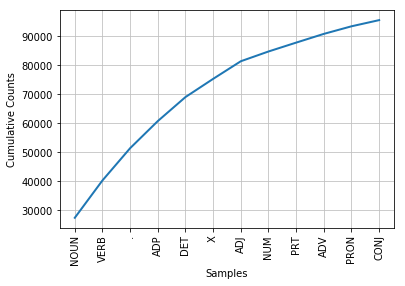

In [11]:
%matplotlib inline
f.plot(cumulative=True)

### Build the vanilla Viterbi based POS tagger

In [12]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]    
    count_w_given_tag = len(w_given_tag_list)
    return (count_w_given_tag, count_tag)

In [13]:
word_given_tag("Google","NOUN")[1]

27423

In [14]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [15]:
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [16]:
tags_matrix

array([[5.31144394e-03, 4.55094166e-02, 9.05359723e-03, 2.04973444e-01,
        4.82858537e-04, 3.74215352e-03, 1.23128919e-02, 1.79864801e-02,
        2.41429268e-04, 3.83872539e-02, 2.19700634e-02, 6.40028954e-01],
       [5.51306568e-02, 7.64818341e-02, 1.42925426e-01, 1.65710635e-02,
        1.03569152e-02, 5.60866781e-02, 2.51752716e-02, 1.63798600e-01,
        1.85787126e-01, 2.03632891e-01, 2.70873168e-03, 6.13448061e-02],
       [3.26377749e-01, 3.40288915e-02, 1.72284637e-02, 1.05296947e-01,
        8.56072758e-04, 6.91278726e-02, 1.31621184e-02, 3.94863561e-02,
        1.49812736e-03, 8.23970046e-03, 6.29213452e-02, 3.21776360e-01],
       [5.10120112e-03, 2.13921349e-02, 7.89863393e-02, 6.66447282e-02,
        1.69491526e-02, 6.58219506e-04, 4.60753683e-03, 6.53282851e-02,
        1.08606219e-02, 1.23416157e-02, 2.04048045e-02, 6.96725368e-01],
       [1.21539183e-01, 7.97747541e-03, 5.44345379e-02, 1.16846554e-01,
        4.69263265e-04, 5.86579069e-02, 5.58423288e-02, 3.42

In [17]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [18]:
tags_df

,DET,X,ADP,ADJ,CONJ,PRON,ADV,.,PRT,VERB,NUM,NOUN
DET,0.005311,0.045509,0.009054,0.204973,0.000483,0.003742,0.012313,0.017986,0.000241,0.038387,0.021970,0.640029
X,0.055131,0.076482,0.142925,0.016571,0.010357,0.056087,0.025175,0.163799,0.185787,0.203633,0.002709,0.061345
ADP,0.326378,0.034029,0.017228,0.105297,0.000856,0.069128,0.013162,0.039486,0.001498,0.008240,0.062921,0.321776
ADJ,0.005101,0.021392,0.078986,0.066645,0.016949,0.000658,0.004608,0.065328,0.010861,0.012342,0.020405,0.696725
CONJ,0.121539,0.007977,0.054435,0.116847,0.000469,0.058658,0.055842,0.034256,0.004693,0.153918,0.042234,0.349132
PRON,0.009549,0.092819,0.022918,0.074866,0.004966,0.008021,0.033995,0.041253,0.012223,0.480901,0.007257,0.211230
ADV,0.067110,0.023588,0.119601,0.130233,0.006312,0.015615,0.081063,0.136877,0.013621,0.344518,0.030565,0.030897
.,0.173502,0.026623,0.091114,0.044972,0.057924,0.065389,0.052078,0.093812,0.002339,0.088505,0.080500,0.223152
PRT,0.100360,0.013403,0.021576,0.086303,0.002288,0.018960,0.010134,0.041517,0.001635,0.402746,0.058516,0.242563
VERB,0.133101,0.218005,0.090493,0.064649,0.005588,0.036244,0.082577,0.035312,0.031121,0.169189,0.022817,0.110904


In [19]:
tags_df.idxmax()[0]

'ADP'

In [20]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [21]:
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

In [22]:
test_tagged_words[:5]

['For', 'the', 'Agency', 'for', 'International']

In [23]:
#Viterbi(['Google'])
tagged_seq = Viterbi(test_tagged_words[:100])

In [24]:
test_run_base = [tup for sent in test_set for tup in sent]

In [25]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base[:100]) if i == j] 

In [26]:
accuracy_vanilla = len(check)/len(tagged_seq)

In [27]:
test_run_base[:5]

[('For', 'ADP'),
 ('the', 'DET'),
 ('Agency', 'NOUN'),
 ('for', 'ADP'),
 ('International', 'NOUN')]

In [28]:
accuracy_vanilla

0.95

In [29]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [30]:
incorrect_tagged_cases

[[('expanded', 'VERB'), (('trade', 'VERB'), ('trade', 'NOUN'))],
 [('the', 'DET'), (('Overseas', 'DET'), ('Overseas', 'NOUN'))],
 [('Overseas', 'NOUN'), (('Private', 'ADJ'), ('Private', 'NOUN'))],
 [('settled', 'VERB'), (('pre-1917', 'DET'), ('pre-1917', 'ADJ'))],
 [('``', '.'), (('Unemployment', 'DET'), ('Unemployment', 'NOUN'))]]

In [31]:
from nltk.tokenize import word_tokenize

test_sentence = """Android is a mobile operating system developed by Google.
Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.
Twitter is an online news and social networking service on which users post and interact with messages known as tweets.
Before entering politics, Donald Trump was a domineering businessman and a television personality.
The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.
This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.
Show me the cheapest round trips from Dallas to Atlanta
I would like to see flights from Denver to Philadelphia.
Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.
NASA invited social media users to experience the launch of ICESAT-2 Satellite."""


words = word_tokenize(test_sentence)

In [32]:
tagged_seq = Viterbi(words)

In [33]:
tagged_seq

[('Android', 'DET'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'DET'),
 ('.', '.'),
 ('Android', 'DET'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'DET'),
 ('worldwide', 'DET'),
 ('on', 'ADP'),
 ('smartphones', 'DET'),
 ('since', 'ADP'),
 ('2011', 'DET'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'DET'),
 ('.', '.'),
 ('Google', 'DET'),
 ('and', 'CONJ'),
 ('Twitter', 'DET'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'DET'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'DET'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'DET'),
 ("'s", 'VERB'),
 ('firehose', 'DET'),
 ('.', '.'),
 ('Twitter', 'DET'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'DET'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NO

### Solve the problem of unknown words

In [34]:
def laplace_smoothing(x,n,d):
    k = 1
    return ((x + k) / (n + k*d))

In [35]:
def findtags(tag_prefix, tagged_text):
    cfd = nltk.ConditionalFreqDist((tag, word) for (word, tag) in tagged_text
                                  if tag.startswith(tag_prefix))
    return dict((tag, cfd[tag].most_common(5)) for tag in cfd.conditions())

In [36]:
tagdict = findtags('NOUN', train_tagged_words)

In [37]:
for tag in sorted(tagdict):
     print(tag, tagdict[tag])

NOUN [('%', 420), ('Mr.', 359), ('company', 244), ('U.S.', 213), ('year', 193)]


In [38]:
nltk.bigrams(train_tagged_words)

<generator object bigrams at 0x7fdea33cf350>

In [39]:
tags = [b[1] for (a, b) in nltk.bigrams(train_tagged_words) if a[0] == 'International']
fd = nltk.FreqDist(tags)
fd.tabulate()

NOUN    .  PRT VERB 
  25    5    1    1 


In [40]:
def process(sentence):
    for (w1,t1), (w2,t2), (w3,t3) in nltk.trigrams(sentence):
        if (t1.startswith('V') and t2 == 'TO' and t3.startswith('V')):
            print(w1, w2, w3)

In [41]:
for tagged_sent in train_tagged_words:
     process(tagged_sent)

In [42]:
t0 = nltk.DefaultTagger('NOUN')
t1 = nltk.UnigramTagger(train_set, backoff=t0)
t2 = nltk.BigramTagger(train_set, backoff=t1)

In [43]:
tag = t2.tag(test_tagged_words[:50])
#print(tag[])

test_run_base[:50]

[('For', 'ADP'),
 ('the', 'DET'),
 ('Agency', 'NOUN'),
 ('for', 'ADP'),
 ('International', 'NOUN'),
 ('Development', 'NOUN'),
 (',', '.'),
 ('appropriators', 'NOUN'),
 ('approved', 'VERB'),
 ('$', '.'),
 ('200', 'NUM'),
 ('million', 'NUM'),
 ('*U*', 'X'),
 ('in', 'ADP'),
 ('secondary', 'ADJ'),
 ('loan', 'NOUN'),
 ('guarantees', 'NOUN'),
 ('under', 'ADP'),
 ('an', 'DET'),
 ('expanded', 'VERB'),
 ('trade', 'NOUN'),
 ('credit', 'NOUN'),
 ('insurance', 'NOUN'),
 ('program', 'NOUN'),
 (',', '.'),
 ('and', 'CONJ'),
 ('total', 'ADJ'),
 ('loan', 'NOUN'),
 ('guarantees', 'NOUN'),
 ('for', 'ADP'),
 ('the', 'DET'),
 ('Overseas', 'NOUN'),
 ('Private', 'NOUN'),
 ('Investment', 'NOUN'),
 ('Corp.', 'NOUN'),
 ('are', 'VERB'),
 ('increased', 'VERB'),
 ('*-3', 'X'),
 ('by', 'ADP'),
 ('$', '.'),
 ('40', 'NUM'),
 ('million', 'NUM'),
 ('*U*', 'X'),
 ('over', 'ADP'),
 ('fiscal', 'ADJ'),
 ('1989', 'NUM'),
 ('as', 'ADP'),
 ('part', 'NOUN'),
 ('of', 'ADP'),
 ('the', 'DET')]

### Modification 1: Laplace Smoothing for word with emmision probability as 0

In [44]:
def Viterbi_with_mod(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag] 

             
            
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            #print("Before: ",emission_p)
            #print(word_given_tag(words[key], tag))
            #If unknown word found
            if word_given_tag(words[key], tag)[0] == 0:
                #print("Before: ",emission_p)
                
                #tag = tags_df.idxmax()[0]
                #tag_new = t2.tag(word)
                #t = [t for w,t in tag_new]
                #Laplace Smoothing to handle Unknown words 
                emission_p = laplace_smoothing(word_given_tag(words[key], tag)[0],word_given_tag(words[key], tag)[1],len(T))

                
                
            state_probability = emission_p * transition_p
            #state_probability = transition_p
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        #print(p)
        #print(max(p))
        state_max = T[p.index(pmax)] 
        #print(state_max)
        state.append(state_max)
        
        
    return list(zip(words, state))

In [45]:
tagged_seq_mod_ac = Viterbi_with_mod(test_tagged_words[:100])
print(tagged_seq_mod_ac)
test_run_base[:100]

[('For', 'ADP'), ('the', 'DET'), ('Agency', 'NOUN'), ('for', 'ADP'), ('International', 'NOUN'), ('Development', 'NOUN'), (',', '.'), ('appropriators', 'CONJ'), ('approved', 'VERB'), ('$', '.'), ('200', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('secondary', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('under', 'ADP'), ('an', 'DET'), ('expanded', 'ADJ'), ('trade', 'NOUN'), ('credit', 'NOUN'), ('insurance', 'NOUN'), ('program', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('total', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Overseas', 'ADJ'), ('Private', 'NOUN'), ('Investment', 'NOUN'), ('Corp.', 'NOUN'), ('are', 'VERB'), ('increased', 'VERB'), ('*-3', 'X'), ('by', 'ADP'), ('$', '.'), ('40', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('over', 'ADP'), ('fiscal', 'ADJ'), ('1989', 'NUM'), ('as', 'ADP'), ('part', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('same', 'ADJ'), ('Poland', 'NOUN'), ('package', 'NOUN'), ('.', '.'), ('The', 'DET'), (

[('For', 'ADP'),
 ('the', 'DET'),
 ('Agency', 'NOUN'),
 ('for', 'ADP'),
 ('International', 'NOUN'),
 ('Development', 'NOUN'),
 (',', '.'),
 ('appropriators', 'NOUN'),
 ('approved', 'VERB'),
 ('$', '.'),
 ('200', 'NUM'),
 ('million', 'NUM'),
 ('*U*', 'X'),
 ('in', 'ADP'),
 ('secondary', 'ADJ'),
 ('loan', 'NOUN'),
 ('guarantees', 'NOUN'),
 ('under', 'ADP'),
 ('an', 'DET'),
 ('expanded', 'VERB'),
 ('trade', 'NOUN'),
 ('credit', 'NOUN'),
 ('insurance', 'NOUN'),
 ('program', 'NOUN'),
 (',', '.'),
 ('and', 'CONJ'),
 ('total', 'ADJ'),
 ('loan', 'NOUN'),
 ('guarantees', 'NOUN'),
 ('for', 'ADP'),
 ('the', 'DET'),
 ('Overseas', 'NOUN'),
 ('Private', 'NOUN'),
 ('Investment', 'NOUN'),
 ('Corp.', 'NOUN'),
 ('are', 'VERB'),
 ('increased', 'VERB'),
 ('*-3', 'X'),
 ('by', 'ADP'),
 ('$', '.'),
 ('40', 'NUM'),
 ('million', 'NUM'),
 ('*U*', 'X'),
 ('over', 'ADP'),
 ('fiscal', 'ADJ'),
 ('1989', 'NUM'),
 ('as', 'ADP'),
 ('part', 'NOUN'),
 ('of', 'ADP'),
 ('the', 'DET'),
 ('same', 'ADJ'),
 ('Poland', 'NOUN'

In [46]:
# accuracy
check_mod = [i for i, j in zip(tagged_seq_mod_ac, test_run_base[:100]) if i == j] 

In [47]:
accuracy_mod = len(check_mod)/len(tagged_seq_mod_ac)

In [48]:
accuracy_mod

0.94

In [66]:
tagged_seq_mod_1 = Viterbi_with_mod(words)

In [67]:
tagged_seq_mod_1

[('Android', 'CONJ'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'DET'),
 ('.', '.'),
 ('Android', 'CONJ'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', '.'),
 ('on', 'ADP'),
 ('smartphones', 'DET'),
 ('since', 'ADP'),
 ('2011', 'DET'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'DET'),
 ('since', 'ADP'),
 ('2013', 'DET'),
 ('.', '.'),
 ('Google', 'CONJ'),
 ('and', 'CONJ'),
 ('Twitter', 'PRON'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'DET'),
 ('that', 'ADP'),
 ('gave', 'DET'),
 ('Google', 'ADJ'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'VERB'),
 ("'s", 'PRT'),
 ('firehose', 'VERB'),
 ('.', '.'),
 ('Twitter', 'CONJ'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'ADJ'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 

In [70]:
print(Diff(tagged_seq_mod_1, tagged_seq))

[('OS', 'NOUN'), ('Atlanta', 'X'), ('arriving', 'PRON'), ('flights', 'X'), ('online', 'ADJ'), ('firehose', 'VERB'), ('Twitter', 'CONJ'), ('NASA', 'CONJ'), ('Satellite', 'ADJ'), ('Twitter', 'PRON'), ('Denver', 'DET'), ('Before', 'CONJ'), ('Google', 'CONJ'), ('domineering', 'ADJ'), ('gave', 'DET'), ('Trump', '.'), ('interact', 'PRON'), ('21st', 'ADJ'), ('Show', 'CONJ'), ('users', '.'), ('2018', 'ADJ'), ('worldwide', '.'), ('Twitter', 'VERB'), ('tournament', '.'), ('Android', 'CONJ'), ('Google', 'ADJ'), ('Cup', '.'), ("'s", 'PRT'), ('politics', 'X'), ('tablets', 'DET'), ('personality', '.'), ('FIFA', 'NOUN'), ('contested', 'CONJ'), ('invited', 'PRON'), ('trips', '.')]


### Some of the words such as OS ,FIFA etc got taggged correctly

### Modification 2: Adding Regex Rule for Unknown word Tagging

In [51]:
from nltk import RegexpTagger

def Viterbi_mod2(words, train_bag = train_tagged_words):
    tagged_seq = Viterbi(words)
    V = list(set([pair[0] for pair in train_bag]))
    
    words = [pair[0] for pair in tagged_seq]
    Viterbi_tags = [pair[1] for pair in tagged_seq]
    
    regexp_tagger = RegexpTagger(
     [(r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),   # cardinal numbers
      (r'(The|the|A|a|An|an)$', 'DET'),   # articles
      (r'.*able$', 'ADJ'),                # adjectives
      (r'.*ness$', 'NOUN'),               # nouns formed from adjectives
      (r'.*ly$', 'ADV'),                  # adverbs
      (r'.*s$', 'NOUN'),                  # plural nouns
      (r'.*ing$', 'VERB'),                # gerunds
      (r'.*ed$', 'VERB'),                 # past tense verbs
      (r'.*', 'NOUN')                     # nouns (default)
     ])

    word_list=[]
    keys =[]
    for key, word in enumerate(words):
        if word not in V:
            word_list.append(word)
            keys.append(key)
            

    tag = regexp_tagger.tag(word_list)
    
    t = [t for w,t in tag]
     
    for key in keys:
        i = 0
        Viterbi_tags[key] = t[i]
        i = i + 1
   
            
    
    return list(zip(words, Viterbi_tags))

#### Evaluating tagging accuracy

In [52]:
tagged_seq_mod = Viterbi_mod2(words)

In [53]:
tagged_seq_mod

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NOUN'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NOUN'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NOUN'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'VERB'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),


In [54]:
tagged_seq_mod_2 = Viterbi_mod2(test_tagged_words[:100])

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [55]:
# accuracy
check_mod = [i for i, j in zip(tagged_seq_mod_2, test_run_base[:100]) if i == j] 

In [56]:
accuracy_mod = len(check_mod)/len(tagged_seq_mod_2)

In [57]:
accuracy_mod

0.97

In [58]:
print ("Vanilla Acccuracy:",accuracy_vanilla)
print ("Accuracy after  Modification:",accuracy_mod)

Vanilla Acccuracy: 0.95
Accuracy after  Modification: 0.97


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [59]:
def Diff(li1, li2): 
    return (list(set(li1) - set(li2))) 

In [60]:
print(Diff(tagged_seq, tagged_seq_mod))

[('NASA', 'DET'), ('online', 'DET'), ('Twitter', 'DET'), ('invited', 'DET'), ('21st', 'DET'), ('tweets', 'DET'), ('domineering', 'DET'), ('interact', 'DET'), ('arriving', 'DET'), ('FIFA', 'DET'), ('Cup', 'DET'), ('Google', 'DET'), ('worldwide', 'DET'), ('smartphones', 'DET'), ('OS', 'DET'), ('Android', 'DET'), ('firehose', 'DET'), ('2015', 'DET'), ('2018', 'DET'), ('trips', 'DET'), ('tournament', 'DET'), ('contested', 'DET'), ('Satellite', 'DET'), ('2013', 'DET'), ('messages', 'DET'), ('personality', 'DET'), ('ICESAT-2', 'DET'), ('2011', 'DET')]


In [61]:
print(Diff(tagged_seq_mod, tagged_seq))

[('worldwide', 'NOUN'), ('smartphones', 'NOUN'), ('OS', 'NOUN'), ('firehose', 'NOUN'), ('Android', 'NOUN'), ('2018', 'NOUN'), ('Satellite', 'NOUN'), ('2015', 'NOUN'), ('2013', 'NOUN'), ('trips', 'NOUN'), ('tournament', 'NOUN'), ('ICESAT-2', 'NOUN'), ('personality', 'NOUN'), ('messages', 'NOUN'), ('contested', 'NOUN'), ('2011', 'NOUN'), ('NASA', 'NOUN'), ('invited', 'NOUN'), ('online', 'NOUN'), ('tweets', 'NOUN'), ('Twitter', 'NOUN'), ('21st', 'NOUN'), ('domineering', 'NOUN'), ('interact', 'NOUN'), ('Cup', 'NOUN'), ('arriving', 'NOUN'), ('Google', 'NOUN'), ('FIFA', 'NOUN')]


In [62]:
incorrect_tagged_cases_after_mod = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_mod_2, test_run_base)) if j[0]!=j[1]]

In [63]:
incorrect_tagged_cases_after_mod

[[('expanded', 'VERB'), (('trade', 'VERB'), ('trade', 'NOUN'))],
 [('Overseas', 'NOUN'), (('Private', 'ADJ'), ('Private', 'NOUN'))],
 [('settled', 'VERB'), (('pre-1917', 'NOUN'), ('pre-1917', 'ADJ'))]]

In [64]:
incorrect_tagged_cases

[[('expanded', 'VERB'), (('trade', 'VERB'), ('trade', 'NOUN'))],
 [('the', 'DET'), (('Overseas', 'DET'), ('Overseas', 'NOUN'))],
 [('Overseas', 'NOUN'), (('Private', 'ADJ'), ('Private', 'NOUN'))],
 [('settled', 'VERB'), (('pre-1917', 'DET'), ('pre-1917', 'ADJ'))],
 [('``', '.'), (('Unemployment', 'DET'), ('Unemployment', 'NOUN'))]]

### Some of the Nouns such as Android , Google ,NASA , FIFA , Twitter got correctly tagged after applying Rule based matrix also accuracy of model increased